https://www.kaggle.com/heatherqiu/ctr-features-gbdt-lr

https://www.kaggle.com/akishen74/ctr-practice/

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

import gc, itertools, time, math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, LabelEncoder, RobustScaler
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import plot_metric
from sklearn.model_selection import train_test_split

这里注意尽量均匀地从训练集中读取数据，仅仅采样数据集中的前n行是不够的。这样处理之后成绩提升了0.005左右

In [2]:
# 连续字段和分类型字段
continue_var = ['I' + str(i) for i in range(1, 14)]
cat_features = ['C' + str(i) for i in range(1,27)]
print("continue_var: ",continue_var)
print("cat_features:", cat_features)

continue_var:  ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13']
cat_features: ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26']


In [3]:
col_names_train = ['Label'] + continue_var + cat_features
col_names_test = col_names_train[1:]
print("col_names_train", col_names_train)
print("col_names_test", col_names_test)

col_names_train ['Label', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26']
col_names_test ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26']


In [4]:
reader = pd.read_csv('/kaggle/input/criteo-dataset/dac/train.txt', sep='\t', 
                     names=col_names_train, chunksize=100000, iterator=True)
train = pd.DataFrame()
print(train.head(10))

Empty DataFrame
Columns: []
Index: []


In [5]:
start = time.time()
for i, chunk in enumerate(reader): 
    if train.shape[0] > 1000000:
        break
    train = pd.concat([train, chunk.sample(frac=.05, replace=False, random_state=911)], axis=0)
    #print(train.shape[0])
    #print(chunk.shape)
    if i % 20 == 0:
        print('Processing Chunk No. {}'.format(i)) 
print('Reading data costs %.2f seconds'%(time.time() - start))

Processing Chunk No. 0
Processing Chunk No. 20
Processing Chunk No. 40
Processing Chunk No. 60
Processing Chunk No. 80
Processing Chunk No. 100
Processing Chunk No. 120
Processing Chunk No. 140
Processing Chunk No. 160
Processing Chunk No. 180
Processing Chunk No. 200
Reading data costs 281.85 seconds


In [6]:
print(train.head(10))

       Label    I1   I2    I3    I4       I5    I6    I7    I8    I9  ...  \
63186      0   NaN    2   3.0   0.0     40.0   NaN   0.0   0.0   3.0  ...   
90005      1   NaN    0   NaN   NaN  14601.0  19.0   1.0   0.0   9.0  ...   
85421      0   2.0  499   3.0   2.0     20.0   2.0   4.0   1.0   3.0  ...   
51870      0   NaN  118   2.0   2.0   6310.0   3.0   1.0   3.0   7.0  ...   
9186       0   1.0    0   NaN  13.0      1.0  13.0   1.0  19.0  13.0  ...   
65480      0   NaN    1   NaN   3.0   9938.0   4.0   5.0   2.0   4.0  ...   
99267      0   NaN    1   2.0   5.0      7.0  63.0   1.0  11.0  67.0  ...   
84476      0   NaN    1  14.0   1.0      NaN   NaN   0.0   1.0   1.0  ...   
37731      1   NaN    5  12.0  12.0   5520.0  33.0  29.0  15.0  45.0  ...   
43358      1  17.0  133   3.0   2.0      1.0   0.0  17.0   2.0   2.0  ...   

            C17       C18       C19       C20       C21       C22       C23  \
63186  776ce399  7b49e3d2       NaN       NaN  73d06dde  ad3062eb  3a171e

In [7]:
# 需要注意的是，测试集样本量是训练集的6倍多
#train = pd.read_csv('/kaggle/input/criteo-dataset/dac/train.txt', 
#                       sep='\t', names=col_names_train,
#                       chunksize=100000) # ten chunks: first 1,000,000

test = pd.read_csv('/kaggle/input/criteo-dataset/dac/test.txt',sep='\t', names=col_names_test)
#train = train.get_chunk(1000000)
print('train has {} rows and {} columns'.format(train.shape[0], train.shape[1]))
print('test has {} rows and {} columns'.format(test.shape[0], test.shape[1]))
#train = train.convert_dtypes()
#test = test.convert_dtypes()

train has 1005000 rows and 40 columns
test has 6042135 rows and 39 columns


<AxesSubplot:>

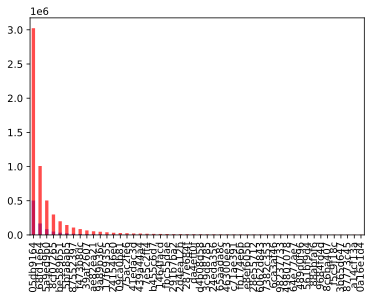

In [8]:
plt.rcParams['figure.facecolor'] = 'white'
train['C1'].value_counts().head(50).plot.bar(color='blue',alpha=0.7)
test['C1'].value_counts().head(50).plot.bar(color='red',alpha=0.7)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005000 entries, 63186 to 20060706
Data columns (total 40 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   Label   1005000 non-null  int64  
 1   I1      551544 non-null   float64
 2   I2      1005000 non-null  int64  
 3   I3      791255 non-null   float64
 4   I4      787532 non-null   float64
 5   I5      976883 non-null   float64
 6   I6      774518 non-null   float64
 7   I7      960500 non-null   float64
 8   I8      1004503 non-null  float64
 9   I9      960500 non-null   float64
 10  I10     551544 non-null   float64
 11  I11     960500 non-null   float64
 12  I12     229927 non-null   float64
 13  I13     787532 non-null   float64
 14  C1      1005000 non-null  object 
 15  C2      1005000 non-null  object 
 16  C3      969759 non-null   object 
 17  C4      969759 non-null   object 
 18  C5      1005000 non-null  object 
 19  C6      869762 non-null   object 
 20  C7      1005000 non

训练集和验证集存在分布不一致的问题。很多id类类别字段的枚举值在测试集中出现，却未在训练集中出现。这也导致了提交后的分数和local cv分数极为不一致。

In [10]:
ls = list(train.columns)
ls.remove('Label')
print(ls)


['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26']


In [11]:
unbalance = []
short = []
print('输出原始数据枚举值对照表')
print('-'*50)
for i in ls:
    train_len = len(train[i].astype(str).value_counts())
    test_len = len(test[i].astype(str).value_counts())
    if (test_len > train_len) and test_len > 100 and train[i].dtype == 'object':
        unbalance.append(i)
    elif (test_len > train_len) and test_len <= 100 and train[i].dtype == 'object':
        short.append(i)
    else:
        pass
    print(i, ' | train: {} | test：{}'.format(train_len, test_len))

输出原始数据枚举值对照表
--------------------------------------------------
I1  | train: 267 | test：416
I2  | train: 4319 | test：6159
I3  | train: 1676 | test：5038
I4  | train: 161 | test：216
I5  | train: 80963 | test：197665
I6  | train: 3904 | test：6423
I7  | train: 1409 | test：2551
I8  | train: 312 | test：571
I9  | train: 3055 | test：4829
I10  | train: 9 | test：10
I11  | train: 124 | test：147
I12  | train: 157 | test：268
I13  | train: 350 | test：508
C1  | train: 1276 | test：1351
C2  | train: 538 | test：554
C3  | train: 356058 | test：1654604
C4  | train: 138633 | test：496952
C5  | train: 264 | test：280
C6  | train: 15 | test：23
C7  | train: 10975 | test：11815
C8  | train: 555 | test：596
C9  | train: 3 | test：3
C10  | train: 31594 | test：55575
C11  | train: 4775 | test：4852
C12  | train: 317159 | test：1426969
C13  | train: 3099 | test：3129
C14  | train: 26 | test：27
C15  | train: 9272 | test：12147
C16  | train: 244079 | test：1029668
C17  | train: 10 | test：10
C18  | train: 3986 | test：4866
C19  | 

In [12]:
print('合并长尾枚举值，使分类特征在训练集与测试集分布一致')
print('-'*50)
print(short)
print(train.shape)
print(train['C25'])

合并长尾枚举值，使分类特征在训练集与测试集分布一致
--------------------------------------------------
['C6', 'C14', 'C22', 'C25']
(1005000, 40)
63186            NaN
90005            NaN
85421       ea9a246c
51870            NaN
9186             NaN
              ...   
20040647    ea9a246c
20022630    cb079c2d
20011522    e8b83407
20017967         NaN
20060706         NaN
Name: C25, Length: 1005000, dtype: object


In [13]:
DISTRI = 0.7 # 数字越大，则枚举值分得越多越详细
start = time.time()
print(test['C6'].astype(str).value_counts())
print(len(test['C6'].astype(str).value_counts()))
print(test['C14'].astype(str).value_counts())
print(len(test['C14'].astype(str).value_counts()))
print(test['C22'].astype(str).value_counts())
print(len(test['C22'].astype(str).value_counts()))
for col in short:
    print('processing: {}'.format(col))
    d1 = train[col].astype(str).value_counts()  # 训练集频数表
    #print('d1',d1)
    envalue = d1[: int(len(d1) * DISTRI)].index   # 取按照频数排序后前n%项目的枚举值
    print(envalue)
    #print(train[col])
    train[col] = np.where(train[col].isin(envalue), train[col], 'longtail')
    test[col] = np.where(test[col].isin(envalue) , test[col], 'longtail')
    #print(train[col])
print("the program costs {:.2f} seconds".format(time.time() - start))
print(test['C6'].astype(str).value_counts())
print(len(test['C6'].astype(str).value_counts()))
print(test['C14'].astype(str).value_counts())
print(len(train['C14'].astype(str).value_counts()))
print(test['C22'].astype(str).value_counts())
print(len(test['C22'].astype(str).value_counts()))

7e0ccccf    2349834
fe6b92e5    1406527
fbad5c96    1332662
nan          487422
13718bbd     181835
6f6d9be8     165662
3bf701e7     115950
e3520422       1029
c05778d5        561
c76aecf6        315
f1f2de2d        169
fdf16bc4         63
3c46edb2         58
3bc1ed4d         30
051f8ea4          4
1eed5c3e          3
51247667          3
fb4fd2a8          3
ef5a8cc6          1
825a7058          1
39a23615          1
ea1bcb5e          1
c60ea68c          1
Name: C6, dtype: int64
23
b28479f6    2083789
07d13a8f    2071964
1adce6ef     967455
64c94865     255839
cfef1c29     184001
051219e6     145371
8ceecbc8      72428
f862f261      71246
32813e21      57643
d2dfe871      38937
ad1cc976      27907
f7c1b33f      18878
0601d3b5      10921
243a4e68       7743
dcd762ee       7363
687dfaf4       5123
26ac7cf4       3356
91233270       2772
cf1fc48d       2640
ab7390e9       2390
e8dce07a       1254
ec19f520       1239
5aebfb83       1154
95a6ab8c        342
0bc7c8c2        317
68541952      

In [14]:
print(unbalance)

['C1', 'C2', 'C3', 'C4', 'C5', 'C7', 'C8', 'C10', 'C11', 'C12', 'C13', 'C15', 'C16', 'C18', 'C19', 'C21', 'C24', 'C26']


In [15]:
DISTRI = 0.5 # 数字越大，则枚举值分得越多越详细
start = time.time()
for col in unbalance:
    print('processing: {}'.format(col))
    d1 = train[col].astype(str).value_counts()  # 训练集频数表
    envalue = d1[: int(len(d1) * DISTRI)].index   # 取按照频数排序后前n%项目的枚举值
    train[col] = np.where((train[col].isin(envalue)) | (train[col].isna()) , train[col], 'longtail')
    test[col] = np.where((test[col].isin(envalue)) | (test[col].isna()), test[col], 'longtail')
print("the program costs {:.2f} seconds".format(time.time() - start))

processing: C1
processing: C2
processing: C3
processing: C4
processing: C5
processing: C7
processing: C8
processing: C10
processing: C11
processing: C12
processing: C13
processing: C15
processing: C16
processing: C18
processing: C19
processing: C21
processing: C24
processing: C26
the program costs 42.66 seconds


In [16]:
print('输出经过处理后的枚举值对照表')
print('-'*50)
for i in ls:
    train_len = len(train[i].astype(str).value_counts())
    test_len = len(test[i].astype(str).value_counts())
    print(i, ' | train: {} | test：{}'.format(train_len, test_len))

输出经过处理后的枚举值对照表
--------------------------------------------------
I1  | train: 267 | test：416
I2  | train: 4319 | test：6159
I3  | train: 1676 | test：5038
I4  | train: 161 | test：216
I5  | train: 80963 | test：197665
I6  | train: 3904 | test：6423
I7  | train: 1409 | test：2551
I8  | train: 312 | test：571
I9  | train: 3055 | test：4829
I10  | train: 9 | test：10
I11  | train: 124 | test：147
I12  | train: 157 | test：268
I13  | train: 350 | test：508
C1  | train: 639 | test：637
C2  | train: 270 | test：268
C3  | train: 178030 | test：51308
C4  | train: 69317 | test：45950
C5  | train: 133 | test：133
C6  | train: 10 | test：10
C7  | train: 5488 | test：5338
C8  | train: 278 | test：278
C9  | train: 3 | test：3
C10  | train: 15798 | test：15666
C11  | train: 2388 | test：2271
C12  | train: 158580 | test：51785
C13  | train: 1550 | test：1531
C14  | train: 19 | test：19
C15  | train: 4637 | test：4568
C16  | train: 122040 | test：54285
C17  | train: 10 | test：10
C18  | train: 1994 | test：1973
C19  | train: 916 

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005000 entries, 63186 to 20060706
Data columns (total 40 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   Label   1005000 non-null  int64  
 1   I1      551544 non-null   float64
 2   I2      1005000 non-null  int64  
 3   I3      791255 non-null   float64
 4   I4      787532 non-null   float64
 5   I5      976883 non-null   float64
 6   I6      774518 non-null   float64
 7   I7      960500 non-null   float64
 8   I8      1004503 non-null  float64
 9   I9      960500 non-null   float64
 10  I10     551544 non-null   float64
 11  I11     960500 non-null   float64
 12  I12     229927 non-null   float64
 13  I13     787532 non-null   float64
 14  C1      1005000 non-null  object 
 15  C2      1005000 non-null  object 
 16  C3      969759 non-null   object 
 17  C4      969759 non-null   object 
 18  C5      1005000 non-null  object 
 19  C6      1005000 non-null  object 
 20  C7      1005000 non

In [18]:
print(continue_var)
fill_mean = lambda x: x.fillna(x.mean())
print(fill_mean)
print(train['I1'])
print(test[col].isna())

['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13']
<function <lambda> at 0x7fc70b898a70>
63186        NaN
90005        NaN
85421        2.0
51870        NaN
9186         1.0
            ... 
20040647     0.0
20022630    18.0
20011522     NaN
20017967     1.0
20060706     2.0
Name: I1, Length: 1005000, dtype: float64
0          False
1          False
2          False
3           True
4          False
           ...  
6042130    False
6042131    False
6042132    False
6042133    False
6042134    False
Name: C26, Length: 6042135, dtype: bool


In [19]:
# 连续型字段用分组均值填充
start = time.time()
for col in continue_var:
    print('filling NA value of {} ...'.format(col))
    train[col] = train[col].groupby(train['C7']).apply(fill_mean)
    print(train[col])
    test[col] = test[col].groupby(test['C7']).apply(fill_mean)
    print(test[col])
    train[col] = train[col].fillna(test[col].mean())
    print(train[col])
    test[col] = test[col].fillna(test[col].mean())
    print(test[col])
    train[col] = train[col].astype('float64')
    print(train[col])
    test[col] = test[col].astype('float64')
    print(test[col])
print("filling NA costs {:.2f} seconds".format(time.time() - start))

train = train.fillna('unknown')
test = test.fillna('unknown')

filling NA value of I1 ...
63186             NaN
90005        0.805556
85421        2.000000
51870        0.869565
9186         1.000000
              ...    
20040647     0.000000
20022630    18.000000
20011522     1.573798
20017967     1.000000
20060706     2.000000
Name: I1, Length: 1005000, dtype: float64
0           3.702016
1          27.000000
2           1.000000
3           4.000000
4           7.000000
             ...    
6042130     0.748299
6042131     1.000000
6042132     2.753286
6042133     0.000000
6042134     0.000000
Name: I1, Length: 6042135, dtype: float64
63186        2.899748
90005        0.805556
85421        2.000000
51870        0.869565
9186         1.000000
              ...    
20040647     0.000000
20022630    18.000000
20011522     1.573798
20017967     1.000000
20060706     2.000000
Name: I1, Length: 1005000, dtype: float64
0           3.702016
1          27.000000
2           1.000000
3           4.000000
4           7.000000
             ...    
604213

https://contrib.scikit-learn.org/category_encoders/targetencoder.html

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6042135 entries, 0 to 6042134
Data columns (total 39 columns):
 #   Column  Dtype  
---  ------  -----  
 0   I1      float64
 1   I2      float64
 2   I3      float64
 3   I4      float64
 4   I5      float64
 5   I6      float64
 6   I7      float64
 7   I8      float64
 8   I9      float64
 9   I10     float64
 10  I11     float64
 11  I12     float64
 12  I13     float64
 13  C1      object 
 14  C2      object 
 15  C3      object 
 16  C4      object 
 17  C5      object 
 18  C6      object 
 19  C7      object 
 20  C8      object 
 21  C9      object 
 22  C10     object 
 23  C11     object 
 24  C12     object 
 25  C13     object 
 26  C14     object 
 27  C15     object 
 28  C16     object 
 29  C17     object 
 30  C18     object 
 31  C19     object 
 32  C20     object 
 33  C21     object 
 34  C22     object 
 35  C23     object 
 36  C24     object 
 37  C25     object 
 38  C26     object 
dtypes: float64(13), objec

In [21]:
y_train = train[['Label']]
x_train = train.drop(['Label'], axis=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, stratify=y_train, random_state=256)
#cat_features = [i for i in range(0, 35)]

In [22]:
x_train

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
15889559,9.000000,2.0,2.000000,7.345247,434.0,3.000000,50.000000,4.0,9.000000,1.000000,...,e5ba7672,e88ffc9d,d7a14759,a458ea53,longtail,ad3062eb,3a171ecb,921af7c4,cb079c2d,77c1aeed
4323975,4.000000,7.0,1.000000,9.000000,5.0,9.000000,4.000000,9.0,9.000000,1.000000,...,e5ba7672,065917ca,unknown,unknown,bd7fd074,c9d4222a,3a171ecb,d4af2638,longtail,unknown
684701,0.000000,-1.0,22.997685,6.344000,2797.0,14.000000,1.000000,5.0,9.000000,0.000000,...,d4bb7bd8,ae288801,21ddcdc9,5840adea,e7f0c6dc,longtail,32c7478e,3e30919e,47907db5,2fede552
12232846,2.778912,0.0,10.936937,1.000000,2921.0,133.000000,1.000000,4.0,47.000000,0.554422,...,e5ba7672,4623da58,unknown,unknown,5dcc9e3d,ad3062eb,3a171ecb,cee0fca8,longtail,unknown
11043541,0.000000,20.0,310.000000,1.000000,38590.0,422.340000,0.150134,18.0,34.640751,0.000000,...,1e88c74f,582152eb,21ddcdc9,5840adea,066228d7,longtail,dbb486d7,166ad104,001f3601,aa5f0a15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6604047,7.000000,29.0,3.000000,3.000000,820.0,3.000000,207.000000,6.0,300.000000,1.000000,...,3486227d,3f9969b8,feb03dbe,a458ea53,98818775,longtail,bcdee96c,c94ffa50,cb079c2d,d5ca783a
14457255,1.000000,0.0,32.000000,21.000000,1205.0,35.000000,5.000000,42.0,43.000000,0.000000,...,e5ba7672,891589e7,a9c2b5a9,b1252a9d,c468ad61,longtail,32c7478e,3fdb382b,ea9a246c,49d68486
18138249,2.961228,3.0,1.000000,5.000000,1805.0,8.000000,2.000000,5.0,5.000000,0.562749,...,07c540c4,87fd936e,unknown,unknown,ec6d8e1a,c9d4222a,dbb486d7,4921c033,longtail,unknown
5346826,5.000000,-1.0,2.000000,6.000000,642.0,41.000000,5.000000,0.0,22.000000,1.000000,...,e5ba7672,longtail,unknown,unknown,longtail,longtail,3a171ecb,488ba19e,longtail,unknown


In [23]:
test.iloc[:,11:35]

,I12,I13,C1,C2,C3,C4,C5,C6,C7,C8,...,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22
0,0.000000,6.000000,5a9ed9b0,a0e12995,a1e14474,08a40877,25c83c98,longtail,964d1fdd,5b392875,...,8b216f7b,1adce6ef,78c64a1d,3ecdadf7,3486227d,1616f155,21ddcdc9,5840adea,2c277e62,longtail
1,0.000000,23.000000,68fd1e64,960c983b,longtail,longtail,25c83c98,7e0ccccf,fe06fd10,062b5529,...,4f8e2224,f862f261,longtail,longtail,e5ba7672,b4abdd09,21ddcdc9,5840adea,longtail,longtail
2,0.452268,2.000000,09ca0b81,8947f767,a87e61f7,c4ba2a67,25c83c98,7e0ccccf,ce6020cc,062b5529,...,aca22cf9,b28479f6,a473257f,88f592e4,d4bb7bd8,bd17c3da,1d04f4a4,a458ea53,82bdc0bb,longtail
3,0.013825,6.000000,05db9164,longtail,a7ded28e,456b4d8c,25c83c98,fbad5c96,5f29da0e,0b153874,...,f9d99d81,cfef1c29,abd8f51e,9a9902d0,07c540c4,bdc06043,unknown,unknown,6dfd157c,ad3062eb
4,2.000000,12.000000,05db9164,207b2d81,2b280564,ad5ffc6b,25c83c98,7e0ccccf,103c17bc,0b153874,...,e9332a03,07d13a8f,0c67c4ca,7d9b60c8,27c07bd6,395856b0,21ddcdc9,a458ea53,9c3eb598,ad3062eb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6042130,0.000000,9.000000,05db9164,c66fca21,longtail,longtail,25c83c98,longtail,bf039a0c,0b153874,...,longtail,07d13a8f,e25cc91e,longtail,d4bb7bd8,1304f63b,21ddcdc9,b1252a9d,longtail,longtail
6042131,0.000000,7.848369,05db9164,207b2d81,longtail,11d45817,25c83c98,fbad5c96,83be4a6a,0b153874,...,cd98af01,b28479f6,899da9d5,7cdd6d45,d4bb7bd8,25c88e42,21ddcdc9,a458ea53,longtail,ad3062eb
6042132,2.123779,5.000000,05db9164,064c8f31,43a795a8,be13fbd1,4cf72387,6f6d9be8,f00bddf8,6c97ac79,...,39795005,b28479f6,93625cba,b06f79e3,e5ba7672,3987fb8a,21ddcdc9,5840adea,45fdf300,longtail
6042133,0.000000,5.000000,68fd1e64,0468d672,622d2ce8,51c64c6d,43b19349,7e0ccccf,9a17f584,0b153874,...,22591fcf,07d13a8f,a888f201,ab8b968d,07c540c4,9880032b,21ddcdc9,5840adea,ee4fa92e,longtail


In [24]:

def plot_catboost(y_label):
    '''plot catboost learning curve
    '''
    learn_error = pd.read_csv('./catboost_info/learn_error.tsv', sep='\t')
    test_error = pd.read_csv('./catboost_info/test_error.tsv', sep='\t')
    metric = pd.concat([learn_error, test_error.iloc[:,1]], axis=1)
    metric.columns = ['iterations','train','test']
    plt.rcParams['figure.facecolor'] = 'white'
    metric.plot(x='iterations',y=['train','test'])
    plt.ylabel(y_label)
    plt.grid()
    plt.show()
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    '''This function prints and plots the confusion matrix.
       Normalization can be applied by setting `normalize=True`.
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.rcParams['figure.facecolor'] = 'white'
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Automatic Feature Selection Using Catboost Feature Importance


首先对训练集建立一个Catboost算法，输出每个特征的重要性，再根据重要性排序，丢弃最不重要的后n%的特征

0:	learn: 0.5940330	test: 0.5913464	best: 0.5913464 (0)	total: 88.9ms	remaining: 8.8s
10:	learn: 0.4879080	test: 0.4844836	best: 0.4844836 (10)	total: 685ms	remaining: 5.54s
20:	learn: 0.4763319	test: 0.4744048	best: 0.4744048 (20)	total: 1.23s	remaining: 4.63s
30:	learn: 0.4719010	test: 0.4709761	best: 0.4709761 (30)	total: 1.81s	remaining: 4.02s
40:	learn: 0.4686024	test: 0.4687614	best: 0.4687614 (40)	total: 2.49s	remaining: 3.58s
50:	learn: 0.4664824	test: 0.4677502	best: 0.4677502 (50)	total: 3.07s	remaining: 2.95s
60:	learn: 0.4649748	test: 0.4670563	best: 0.4670563 (60)	total: 3.67s	remaining: 2.35s
70:	learn: 0.4634971	test: 0.4665998	best: 0.4665998 (70)	total: 4.25s	remaining: 1.73s
80:	learn: 0.4622456	test: 0.4663765	best: 0.4663374 (79)	total: 4.83s	remaining: 1.13s
90:	learn: 0.4610347	test: 0.4663003	best: 0.4663003 (90)	total: 5.84s	remaining: 578ms
99:	learn: 0.4598577	test: 0.4660671	best: 0.4660671 (99)	total: 6.4s	remaining: 0us
bestTest = 0.4660670864
bestIteration

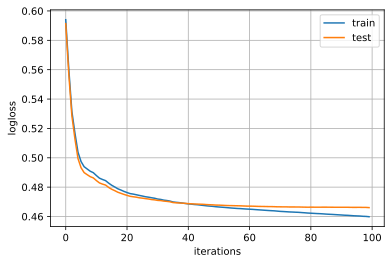

,feature,importance
5,I6,17.503040
19,C7,7.143183
27,C15,5.883975
10,I11,5.686823
4,I5,3.773483
35,C23,3.583182
36,C24,3.548417
15,C3,3.317385
38,C26,3.203710
24,C12,2.960313


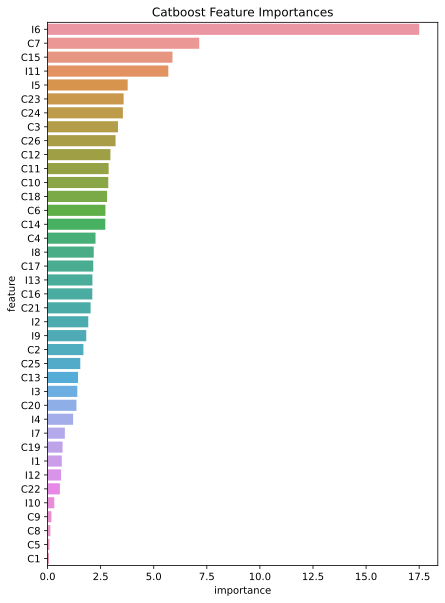

In [25]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.4,
    task_type='GPU',
    loss_function='Logloss',
    depth=8,
)

fit_model = model.fit(
    x_train, y_train,
    eval_set=(x_val, y_val),
    cat_features = cat_features,
    verbose=10
)

feature_im = fit_model.feature_importances_

plot_catboost('logloss')


def feature_selection(features, feature_importance, DISTRI=0.7, selection=False, plot=True):
    '''do feature selection
    '''
    feimp = pd.DataFrame({'feature': features,
                          'importance': feature_importance}).sort_values(by=['importance'], 
                                                           ascending=False)
    if selection:
        feimp = feimp.iloc[: int(feimp.shape[0] * DISTRI),]
    else:
        pass
    
    if plot:
        plt.figure(figsize=(7, 10))
        sns.barplot(data = feimp, x='importance', y='feature')
        plt.title('Catboost Feature Importances')
    else:
        pass
    return feimp
    
feimp = feature_selection(x_train.columns, feature_im, 0.7)
feimp

In [26]:
feimp.shape[0]

39

In [27]:

feimp = feature_selection(x_train.columns, feature_im, 0.7, selection=True, plot=False)
feimp


,feature,importance
5,I6,17.503040
19,C7,7.143183
27,C15,5.883975
10,I11,5.686823
4,I5,3.773483
35,C23,3.583182
36,C24,3.548417
15,C3,3.317385
38,C26,3.203710
24,C12,2.960313


In [28]:
feimp.shape[0]

27

## Catboost Fitting for Prediction

In [29]:
x_train = x_train[feimp['feature']]
x_val = x_val[feimp['feature']]
test = test[feimp['feature']]

In [30]:
cat_features0 = [i for i in feimp['feature'] if 'C' in i]
cat_features0

['C7',
 'C15',
 'C23',
 'C24',
 'C3',
 'C26',
 'C12',
 'C11',
 'C10',
 'C18',
 'C6',
 'C14',
 'C4',
 'C17',
 'C16',
 'C21',
 'C2',
 'C25',
 'C13']

0:	learn: 0.5942070	test: 0.5915543	best: 0.5915543 (0)	total: 154ms	remaining: 15.3s
10:	learn: 0.4848518	test: 0.4813111	best: 0.4813111 (10)	total: 783ms	remaining: 6.33s
20:	learn: 0.4756802	test: 0.4734880	best: 0.4734880 (20)	total: 1.39s	remaining: 5.24s
30:	learn: 0.4720552	test: 0.4708788	best: 0.4708788 (30)	total: 2.01s	remaining: 4.48s
40:	learn: 0.4695757	test: 0.4695185	best: 0.4695185 (40)	total: 2.61s	remaining: 3.76s
50:	learn: 0.4679175	test: 0.4688158	best: 0.4688158 (50)	total: 3.22s	remaining: 3.09s
60:	learn: 0.4660164	test: 0.4680387	best: 0.4680387 (60)	total: 3.81s	remaining: 2.44s
70:	learn: 0.4646438	test: 0.4677007	best: 0.4676906 (68)	total: 4.5s	remaining: 1.84s
80:	learn: 0.4635202	test: 0.4674104	best: 0.4674104 (80)	total: 5.08s	remaining: 1.19s
90:	learn: 0.4622400	test: 0.4671913	best: 0.4671904 (89)	total: 5.67s	remaining: 560ms
99:	learn: 0.4612751	test: 0.4670112	best: 0.4670112 (99)	total: 6.22s	remaining: 0us
bestTest = 0.4670112329
bestIteration

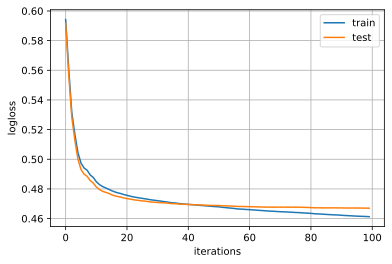

Out of folds logloss is 0.4670


,Id,Predicted
0,60000000,0.070752
1,60000001,0.210776
2,60000002,0.355429
3,60000003,0.257365
4,60000004,0.089113
...,...,...
6042130,66042130,0.046285
6042131,66042131,0.159307
6042132,66042132,0.482146
6042133,66042133,0.214521


In [31]:
model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.4,
    task_type='GPU',
    loss_function='Logloss',
     #gpu_ram_part=0.9,
     #boosting_type='Plain',
     #max_ctr_complexity=2,
     depth=8,
     #gpu_cat_features_storage='CpuPinnedMemory'
)

fit_model = model.fit(
    x_train, y_train,
    eval_set=(x_val, y_val),
    cat_features=cat_features0,
    verbose=10
)

feature_im = fit_model.feature_importances_

plot_catboost('logloss')


y_test = model.predict(test, 
                       prediction_type='Probability',
                       ntree_end=model.get_best_iteration(), 
                       thread_count=-1,
                       verbose=None)

y_val_pred = model.predict(x_val, 
                       prediction_type='Probability',
                       ntree_start=0,
                       ntree_end=model.get_best_iteration(), 
                       thread_count=-1,
                       verbose=None)

y_test_pred = y_test[:,1]
y_val_pred = y_val_pred[:,1]
y_val_class = np.where(y_val_pred > 0.5,1,0)
print('Out of folds logloss is {:.4f}'.format(log_loss(y_val, y_val_pred)))

submission = pd.read_csv('../input/criteo-display-ad-challenge/random_submission.zip', compression='zip')
submission = pd.DataFrame({'Id': submission['Id'], 'Predicted': y_test_pred })
submission.to_csv('submission.csv',index = False)

submission = pd.DataFrame({'Id': submission['Id'], 'Predicted': y_test_pred * 0.98})
submission.to_csv('submission2.csv',index = False)

submission = pd.DataFrame({'Id': submission['Id'], 'Predicted': y_test_pred * 1.02})
submission.to_csv('submission3.csv',index = False)
submission

Text(0.5, 1.0, 'Catboost Feature Importances')

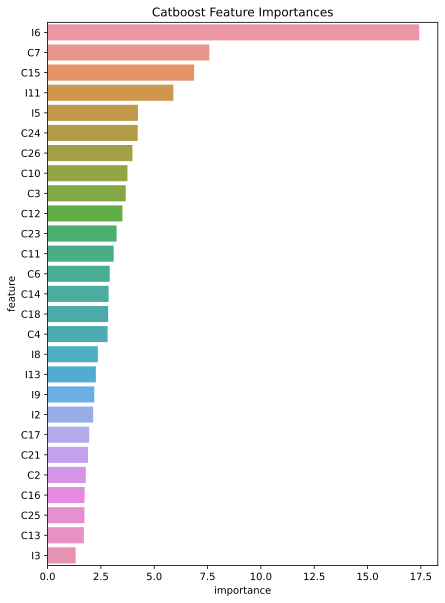

In [32]:
feimp = pd.DataFrame({'feature': x_train.columns,
              'importance': feature_im }).sort_values(by=['importance'], 
                                                           ascending=False)
plt.figure(figsize=(7, 10))
sns.barplot(data = feimp, x='importance', y='feature')
plt.title('Catboost Feature Importances')

Normalized confusion matrix
[[0.94278934 0.05721066]
 [0.69052615 0.30947385]]


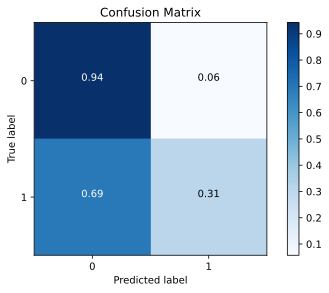

In [33]:
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_val, y_val_class),
                      classes=class_names, 
                      normalize=True, 
                      title='Confusion Matrix')